In [1]:
%pylab
%matplotlib inline
rc('text', usetex = True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as fits
from numpy import polyfit
from astropy.utils.data import download_file
import pandas as pd
from lmfit import Parameters, minimize

In [3]:
### Download data


### Cepheid table
cepheid_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t2_mrt.txt', 
        cache = True)
cepheids = pd.read_csv(cepheid_table,
                       delim_whitespace = True,
                       skiprows = 39,
                       names = (['Field', 'RAdeg', 
                                 'DEdeg', 'ID', 
                                 'Period', 'VtoI', 
                                 'F160Wmag', 'e_F160Wmag',
                                 'Offset', 'Bias', 
                                 'IMrms', 'ObyH', 'Flag']
                               )
                      )

cepheids=cepheids.fillna(value = '-')
### SNe table
Sne_table = download_file(
        'http://iopscience.iop.org/0004-637X/730/2/119/suppdata/apj383673t3_ascii.txt',
        cache = True)
Sne = pd.read_csv(Sne_table, 
                   
                  delim_whitespace=True, 
                  skiprows = [0,1,2,3,4,13,15],
                  names = (['Host', 'junk','Sn1A',
                            'Filters', 'm0_viPlus5a_v',
                            'sigma', 'DeltaMu_0','e_DeltaMu_0',
                            'mu_0_Best', 'e_mu_0_Best'
                          ])
                 )
Sne.loc[:,'e_DeltaMu_0'] = (Sne.loc[:,'e_DeltaMu_0'].apply(str).str.replace('\(|\)','')).astype('float')
Sne.loc[:,'e_mu_0_Best'] = (Sne.loc[:,'e_mu_0_Best'].apply(str).str.replace('\(|\)','')).astype('float')


maser_distance = {'mu':7.2, 'e_mu':0.32} 
maser_distance = pd.DataFrame(data = maser_distance, index = arange(1))

In [4]:
cepheids;

In [5]:
Sne;

In [6]:
class CosmoModel(object):
    def __init__(self, cepheids, Sne, ignore_field = None, IMrms_cut = None, flip_cut = False):
        
        self.cepheids = cepheids.copy()
        self.Sne = Sne.copy()
        self.fields = set(self.cepheids.Field)
        if IMrms_cut is None: IMrms_cut = [0, np.inf]
        if ignore_field is not None:

            ## Remove the fields in ignore_fields from the sample
            self.fields.discard(ignore_field)
        
        ####Cuts
        self.cepheids = self.cepheids.loc[self.cepheids.Flag != 'rej',:]
        self.cepheids = self.cepheids.loc[self.cepheids.Flag !='rej,low',:]
        self.cepheids = self.cepheids.loc[self.cepheids.Flag !='low',:]
        #self.cepheids = self.cepheids.loc[(5.297 < self.cepheids.Period) & (self.cepheids.Period < 203.3), :]
        if flip_cut is False:
            self.cepheids = self.cepheids.loc[self.cepheids.IMrms < IMrms_cut[1],:]
            self.cepheids = self.cepheids.loc[self.cepheids.IMrms > IMrms_cut[0],:]
        else:
            self.cepheids = self.cepheids[(self.cepheids.IMrms >= IMrms_cut[1]) | (self.cepheids.IMrms <= IMrms_cut[0])] 
            #self.cepheids = self.cepheids.loc[self.cepheids.IMrms <= IMrms_cut[0],:]

        if ignore_field is not None:
                self.cepheids = self.cepheids.loc[self.cepheids.Field != ignore_field,:]
                self.Sne = self.Sne.loc[self.Sne.Host != ignore_field, :]
        print 'kept %4.0f total cepheids'%self.cepheids.shape[0]

        self.params = Parameters()
        self.params.add('z_p_n4258', value = 25.5)
        self.params.add('b', value = -3, vary = True)
        self.params.add('Z', value = 0.25, vary = True)
        self.params.add('a_nu', value = 0.47)
        for field in self.fields:
                self.params.add('dmu_'+field, value = 0)
                self.params.add('R_'+field, value = 0, vary = False)
        #        self.params.add('ddmu_'+field, value = 0)
        #self.params['ddmu_n4258'].vary = False
        self.params['dmu_n4258'].vary = False
        self.params['dmu_n4258'].value = 0
        self.params.add('m04258', value = 30)
        self.params.add('m04258bias', value = 0, vary = False)
        self.params.add('mu_geometric', value = 7.6)
        self.params.add('R', value = 0.410, vary = False)
        self.params.add('R2', value = 0, vary = False)
        self.params.add('Q', value = 0, vary = False)
    def Fitted_Mag(self, cepheids, **params):
        
        cepheids.loc[:,'FittedMag'] = (params['z_p_n4258'] 
                        + params['b'] * log10(cepheids.Period) 
                        + params['Z'] * (cepheids.ObyH - mean(cepheids.ObyH))##8.9)#mean(cepheids.loc[cepheids.Field == 'n4258', 'ObyH'])) 
                        + params['R'] * cepheids.VtoI
                        + params['R2'] * cepheids.VtoI**2
                        + params['Q'] * cepheids.Bias
                       )
        for field in (self.fields):
            cepheids.loc[cepheids.Field == field,'FittedMag'] = (cepheids.loc[cepheids.Field == field, 'FittedMag'] 
                                                                 + params['dmu_'+field]
                                                                 + params['R_'+field] * cepheids.VtoI
                                                                )
        return cepheids
    
    def Fitted_Sne(self, Sne, **params):

        Sne.loc[:, 'fitted_abs_mag'] = params['m04258'] + params['m04258bias']
        for field in self.fields:
            Sne.loc[Sne.Host == field, 'fitted_abs_mag'] += params['dmu_'+field]

        return Sne
    
    def ceph_residual(self, cepheids, **params):
        cepheids.loc[:,:] = self.Fitted_Mag(cepheids, **params)
        result = (self.cepheids.F160Wmag-cepheids.FittedMag)/self.cepheids.e_F160Wmag
        return result
    
    def Sne_residual(self, Sne, **params):
        Sne.loc[:,:] = self.Fitted_Sne(Sne, **params)
        result = (self.Sne.m0_viPlus5a_v - 5 * 0.698 - self.Sne.fitted_abs_mag)/self.Sne['sigma']
        return result

    def priors(self, params):
        ### A_nu
        result = [(params['a_nu'] - 0.698)/0.00225]
        result+=[(params['mu_geometric'] - 7.6)/0.3]
        for field in (self.fields):
            result += [params['R_'+field]/0.2]
        #result+=[(params['b'] + 3.3)/0.1]
        #result+=[(params['Z'] + .21)/0.09]
        #result+=[(params['z_p_n4258'] - 26.36)/0.07]
        return array(result)
    
    def residual(self, params):
        Sne_result = self.Sne_residual(self.Sne, **params)
        ceph_result = self.ceph_residual(self.cepheids, **params)
        prior_result = self.priors(params)
        #weights = self.cepheids.IMrms / sum(self.cepheids.IMrms)
        result = concatenate((Sne_result, ceph_result, prior_result))
        #result = sum(Sne_result)
        #result += sum(ceph_result)# /weights)
        #result += sum(prior_result)
        return result
    
    def __call__(self):
        out = minimize(self.residual, 
                       self.params,
                       scale_covar = False
                      #method = 'cg'
                       )
        self.H0 = 10**(out.params['a_nu'].value + 5 + 
                       0.2 * (out.params['m04258'].value - 5*log10(out.params['mu_geometric'].value) - 25))
        #print  5*log10(out.params['mu_geometric'].value) + 25
        self.e_H0 = model.H0 * sqrt((out.params['a_nu'].stderr * log(10))**2 
                            + (log(10)/5 *out.params['m04258'].stderr )**2
                            + (out.params['mu_geometric'].stderr/out.params['mu_geometric'].value)**2)
        return out


kept  375 total cepheids
removing field n3370
H_0 = 73.06 \pm 3.49
z_p_n4258 = 26.22 \pm 0.09
b = -2.94 \pm 0.06
Z = -0.18 \pm 0.10
a_nu = 0.70 \pm 0.00
m04258 = 10.23 \pm 0.06
mu_geometric = 7.60 \pm 0.30


kept  395 total cepheids
removing field n4536
H_0 = 74.12 \pm 3.53
z_p_n4258 = 26.27 \pm 0.10
b = -2.98 \pm 0.07
Z = -0.30 \pm 0.10
a_nu = 0.70 \pm 0.00
m04258 = 10.26 \pm 0.06
mu_geometric = 7.60 \pm 0.30


kept  422 total cepheids
removing field n3982
H_0 = 74.83 \pm 3.58
z_p_n4258 = 26.22 \pm 0.09
b = -2.94 \pm 0.06
Z = -0.24 \pm 0.11
a_nu = 0.70 \pm 0.00
m04258 = 10.28 \pm 0.06
mu_geometric = 7.60 \pm 0.30


kept  366 total cepheids
removing field n5584
H_0 = 72.62 \pm 3.46
z_p_n4258 = 26.25 \pm 0.09
b = -2.96 \pm 0.06
Z = -0.27 \pm 0.10
a_nu = 0.70 \pm 0.00
m04258 = 10.22 \pm 0.06
mu_geometric = 7.60 \pm 0.30


kept  419 total cepheids
removing field n4639
H_0 = 73.41 \pm 3.50
z_p_n4258 = 26.27 \pm 0.09
b = -2.97 \pm 0.06
Z = -0.23 \pm 0.10
a_nu = 0.70 \pm 0.00
m04258 = 10.24 

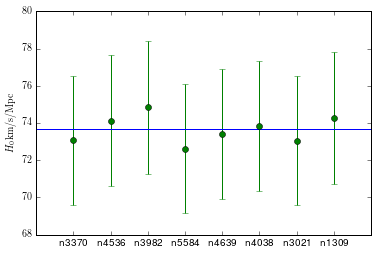

In [29]:
fields = set(cepheids.Field)
ticks = []
hvals = []
herr = []
for field in fields:
    if field != 'n4258':
        model = CosmoModel(cepheids, Sne, ignore_field = field)
        result = model()
        print 'removing field', field
        print 'H_0 = %3.2f \pm %3.2f'%(model.H0, model.e_H0)
        hvals.append(model.H0)
        herr.append(model.e_H0)
        ticks.append(field)
        for key in result.params.keys():
            if result.params[key].vary == True:
                if key[:4] != 'dmu_':
                    print '%s = %3.2f \pm %3.2f'%(key, result.params[key].value, result.params[key].stderr)
        print '\n'
        
    else:
        model = CosmoModel(cepheids, Sne, ignore_field = None)
        result = model()
        print 'keeping all fields'
        print 'H_0 = %3.2f \pm %3.2f'%(model.H0, model.e_H0)
        for key in result.params.keys():
            if result.params[key].vary == True:
                if key[:4] != 'dmu_':
                    print '%s = %3.2f \pm %3.2f'%(key, result.params[key].value, result.params[key].stderr)
        print '\n'
        plot([0,9], [model.H0]*2)
errorbar(arange(1,9), hvals, yerr = herr, fmt = 'o')
xticks(arange(1,9), ticks)

ylabel(r'$H_0  {\rm km/s/Mpc}$')


In [7]:
model = CosmoModel(cepheids, Sne)
result = model()
print 'H_0 = %3.3f \pm %3.3f'%(model.H0, model.e_H0)
print '\chi^2 is ', result.chisqr, 'on around %4.0f degrees of freedom'%(model.cepheids.shape[0])
print 'reduced chisquare is %3.3f'%(result.chisqr/(model.cepheids.shape[0]+model.Sne.shape[0]+3 - 14))
for key in result.params.keys():
    if result.params[key].vary == True:
        print '%s = %3.3f \pm %3.3f'%(key, result.params[key].value, result.params[key].stderr)


kept  444 total cepheids
H_0 = 73.656 \pm 3.454
\chi^2 is  440.902881583 on around  444 degrees of freedom
reduced chisquare is 1.000
z_p_n4258 = 26.253 \pm 0.089
b = -2.961 \pm 0.060
Z = -0.240 \pm 0.093
a_nu = 0.698 \pm 0.002
dmu_n3370 = 2.719 \pm 0.046
dmu_n4536 = 1.552 \pm 0.043
dmu_n3982 = 2.316 \pm 0.059
dmu_n5584 = 2.312 \pm 0.043
dmu_n4639 = 2.276 \pm 0.059
dmu_n4038 = 2.222 \pm 0.068
dmu_n3021 = 2.874 \pm 0.076
dmu_n1309 = 3.126 \pm 0.056
m04258 = 10.250 \pm 0.054
mu_geometric = 7.600 \pm 0.300


In [27]:
percent_error = {}
for key in result.params.keys():
    if result.params[key].value != 0:
        percent_error[key] = result.params[key].stderr/result.params[key].value * 100
    else:
        percent_error[key] = 0
print percent_error['a_nu'], percent_error['m04258'], percent_error['mu_geometric']

0.322349570964 0.524714717701 4.21052630259


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Host,junk,Sn1A,Filters,m0_viPlus5a_v,sigma,DeltaMu_0,e_DeltaMu_0,mu_0_Best,e_mu_0_Best,mu_4258
5,n1309,SN,2002fk,BVRI,16.768,0.103,3.276,0.0491,32.59,0.09,29.314
4,n3021,SN,1995al,UBVRI,16.699,0.113,3.138,0.0870,32.27,0.08,29.132
2,n3370,SN,1994ae,UBVRI,16.545,0.101,2.835,0.0284,32.13,0.07,29.295
3,n3982,SN,1998aq,UBVRI,15.953,0.091,2.475,0.0460,31.70,0.08,29.225
7,n4038,SN,2007sr,BVRI,15.901,0.137,2.396,0.0567,31.66,0.08,29.264
0,n4536,SN,1981B,UBVR,15.147,0.145,1.567,0.0404,30.91,0.07,29.343
1,n4639,SN,1990N,UBVRI,16.040,0.111,2.383,0.0630,31.67,0.08,29.287
6,n5584,SN,2007af,BVRI,16.274,0.122,2.461,0.0401,31.72,0.07,29.259


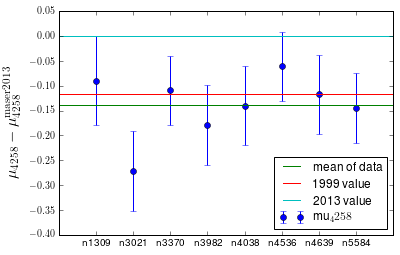

In [10]:
Sne = Sne.sort('Host')
Sne.loc[:,'mu_4258'] = Sne.mu_0_Best.values - Sne.DeltaMu_0.values
true_dist = 5*log10(7.6) + 25
error = Sne.e_mu_0_Best
errorbar(arange(1,9), Sne.mu_4258-true_dist, yerr= error, fmt = 'o')
#errorbar(arange(1,9), values - SneMerged.ddmu, yerr= error, fmt = 'o')
#fill_between([0,9], 
#             [5*log10(result.params['mu_geometric'].value + result.params['mu_geometric'].stderr) + 25]*2, 
#            y2 = [5*log10(result.params['mu_geometric'].value - result.params['mu_geometric'].stderr) + 25]*2,
#             color = 'g',
#             alpha = 0.5
#            )
plot([0,9], [mean(Sne.mu_4258)-true_dist]*2, label = 'mean of data')
plot([0,9], [5*log10(7.2) + 25-true_dist]*2, label = '1999 value')
plot([0,9], [5*log10(7.6) + 25-true_dist]*2, label = '2013 value')
ylabel (r'$\mu_{4258}-{\mu}_{4258}^{\rm maser 2013}$', fontsize = 16)
xlim(0,9)
legend(loc = 4)
xticks(arange(1,9),Sne.Host.values);
Sne

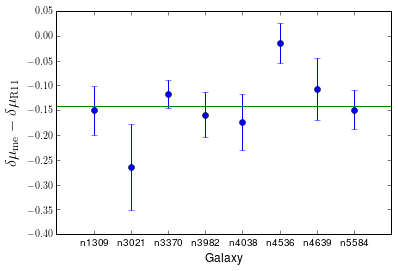

In [11]:
features = ['Period', 'VtoI', 'F160Wmag', 'Bias', 'ObyH']

averages = dict((el, [] ) for el in features)
averages['ddmu'] = []
averages = pd.DataFrame(averages)
#print averages
count = 1
for i,field in enumerate(model.fields):
    if field != 'n4258':
        subframe = model.cepheids.loc[model.cepheids.Field == field, features]
        dmuR11 = Sne.loc[Sne.Host == field, 'DeltaMu_0'].values
        dmuMe = result.params['dmu_'+field]
        #print field, count, dmuR11 - dmuMe
        #subframe.loc[:,'d_dmu'] = [dmuR11 - dmuMe]*subframe.loc[:,'Period'].values.size
        meandict = subframe.mean().to_dict()
        meandict['ddmu'] = dmuR11 - dmuMe 
        meandict['Host'] = field
        #print count, meandict
        meanframe = pd.DataFrame(meandict, index = [i])
        #if count == 3: print meanframe 
        count = count + 1
        averages= averages.append(meanframe)
    
averages = averages.sort_values(by = 'Host')
averages.loc[:,'ddmu'] = averages.loc[:,'ddmu'] 
errorbar(arange(1,9), -averages.ddmu.values, yerr = Sne.e_DeltaMu_0, fmt = 'o')
plot([0,9], [mean(-averages.ddmu.values)]*2)
xlabel ('Galaxy', fontsize = 12)
ylabel (r'$\delta \mu_{\rm me} - \delta \mu_ {\rm R11}$', fontsize = 16)
xticks(arange(1,9),averages.Host.values)
xlim(0, 9);

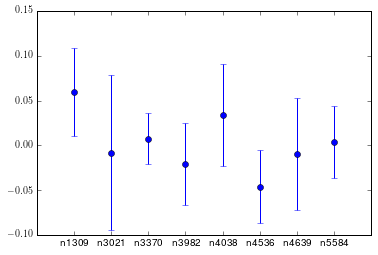

In [12]:
SneMerged = pd.merge(Sne,averages, on = 'Host')
errorbar(arange(1,9), SneMerged.mu_4258 + SneMerged.ddmu - true_dist, yerr = SneMerged.e_DeltaMu_0, fmt = 'o')
xticks(arange(1,9), SneMerged.Host.values)
xlim(0,9);


In [13]:
features = ['Period', 'VtoI', 'F160Wmag', 'Bias', 'ObyH']

averages = dict((el, [] ) for el in features)
averages['ddmu'] = []
averages = pd.DataFrame(averages)#, index = arange(1) )
#print averages
count = 1
for field in model.fields:
    if field != 'n4258':
        subframe = model.cepheids.loc[model.cepheids.Field == field, features]
        dmuR11 = Sne.loc[Sne.Host == field, 'DeltaMu_0'].values
        dmuMe = result.params['dmu_'+field]
        #print field, count, dmuR11 - dmuMe
        #subframe.loc[:,'d_dmu'] = [dmuR11 - dmuMe]*subframe.loc[:,'Period'].values.size
        meandict = subframe.mean().to_dict()
        meandict['ddmu'] = dmuR11 - dmuMe
        #print count, meandict
        meanframe = pd.DataFrame(meandict, index = [field])
        #if count == 3: print meanframe 
        count = count + 1
        averages= averages.append(meanframe)
    
#averages = averages.loc[1:, :]
param1 = []
param2 = []
#for key in field_averages.keys():
#    param1.append(field_averages[key].VtoI)
#    params2.append(field_averages[])
averages.corr()
averages.F160Wmag

n3370    24.509710
n4536    24.046122
n3982    24.622273
n5584    24.301795
n4639    24.275200
n4038    23.672812
n3021    24.830000
n1309    24.700667
Name: F160Wmag, dtype: float64

In [14]:
print 'Field\tR11 vs Me\tR11 Error\tMy Error'
residual_difference = 0
for key in result.params.keys():
    if key[0:3] == 'dmu':
        if key != 'dmu_n4258':
            dmeR11 = (result.params[key].value 
                      - Sne.loc[Sne['Host']==key[4:],'DeltaMu_0'].values
                      + result.params['m04258bias']
                      )
            residual_difference += dmeR11
            print '%s\t%f\t%f\t%f'%(key[4:], 
                dmeR11, 
                (Sne.loc[Sne['Host']==key[4:], 'e_DeltaMu_0'].values),
                result.params[key].stderr
                               )
print 'mean offset is', residual_difference[0]/8

Field	R11 vs Me	R11 Error	My Error
n3370	-0.116496	0.028400	0.045186
n4536	-0.014866	0.040400	0.042891
n3982	-0.158523	0.046000	0.058033
n5584	-0.148592	0.040100	0.042639
n4639	-0.107415	0.063000	0.058034
n4038	-0.173975	0.056700	0.067770
n3021	-0.263735	0.087000	0.074824
n1309	-0.149708	0.049100	0.055896
mean offset is -0.141663654355


In [15]:
print 'param \t \t value \t \t error \t \t % error'
for key in result.params.keys():
    if len(key)< 8: 
        disp_key = '%s\t'%key
    else:
        disp_key = key
    if result.params[key].vary != False:
        print '%s \t %f \t %f \t %f'%(disp_key, 
                                   result.params[key].value, 
                                   result.params[key].stderr, 
                                   abs(result.params[key].stderr/result.params[key].value)*100
                                  )

H_0_error = model.H0 * sqrt((result.params['a_nu'].stderr * log(10))**2 
                            + (log(10)/5 *result.params['m04258'].stderr )**2
                            + (result.params['mu_geometric'].stderr/result.params['mu_geometric'].value)**2)

H_0_frac_error = H_0_error/model.H0
print '%s \t %f \t %f \t %f'%('H_0      ',model.H0,H_0_error , H_0_frac_error)

param 	 	 value 	 	 error 	 	 % error
z_p_n4258 	 26.253080 	 0.087733 	 0.334183
b	 	 -2.961105 	 0.059549 	 2.011028
Z	 	 -0.240323 	 0.092143 	 38.341245
a_nu	 	 0.698000 	 0.002230 	 0.319430
dmu_n3370 	 2.718504 	 0.045186 	 1.662149
dmu_n4536 	 1.552134 	 0.042891 	 2.763331
dmu_n3982 	 2.316477 	 0.058033 	 2.505247
dmu_n5584 	 2.312408 	 0.042639 	 1.843927
dmu_n4639 	 2.275585 	 0.058034 	 2.550298
dmu_n4038 	 2.222025 	 0.067770 	 3.049924
dmu_n3021 	 2.874265 	 0.074824 	 2.603237
dmu_n1309 	 3.126292 	 0.055896 	 1.787942
m04258	 	 10.250109 	 0.053297 	 0.519962
mu_geometric 	 7.600000 	 0.317101 	 4.172388
H_0       	 73.656003 	 3.585503 	 0.048679


0.988198412638 0.124034734589
1.3042014685 0.1490711985
1.37870802324 0.235702260396
1.10367278794 0.116247638744
1.48339738047 0.218217890236
1.1362440982 0.188982236505
0.987510394535 0.0940720868384
0.903957787281 0.235702260396
0.913918507065 0.196116135138


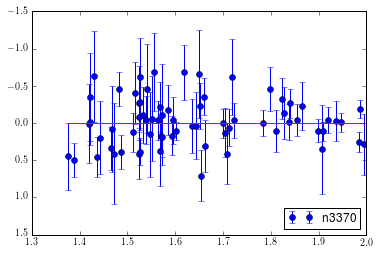

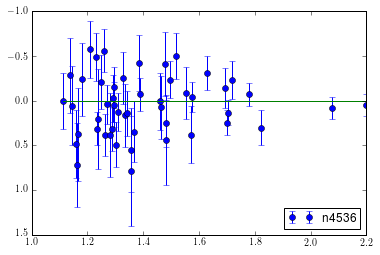

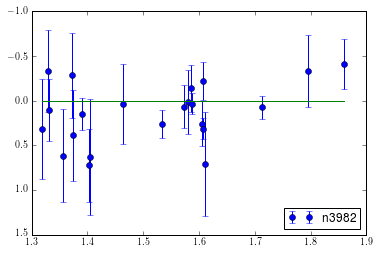

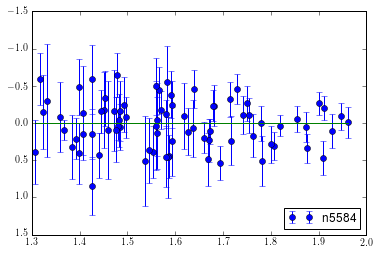

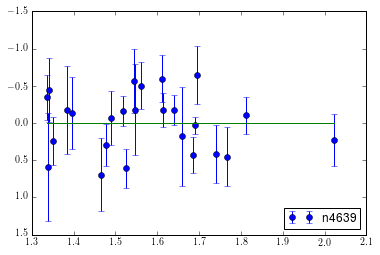

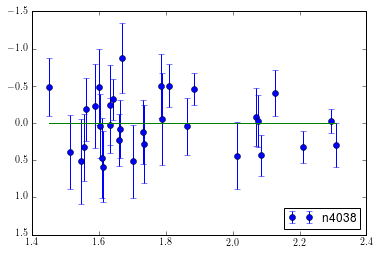

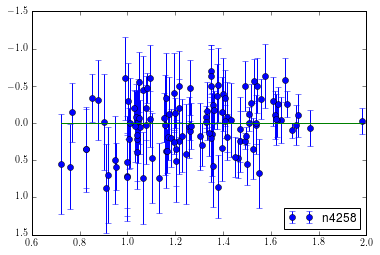

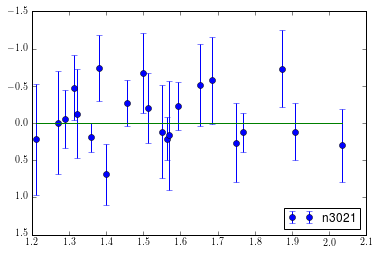

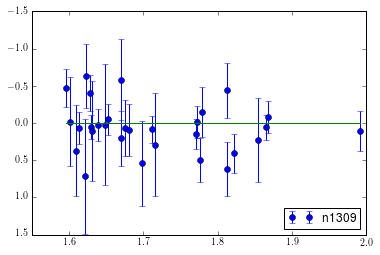

In [16]:
fields = set(model.cepheids.Field)
for i, field in enumerate(fields):
    figure()
    x = log10(model.cepheids.loc[model.cepheids.Field == field, 'Period'])
    #result.params['b'].value * log10(model.cepheids.loc[model.cepheids.Field == field, 'Period'].values)
    y = (model.cepheids.loc[model.cepheids.Field ==field, 'F160Wmag'].values 
         -result.params['R'] * model.cepheids.loc[model.cepheids.Field == field, 'VtoI']
         -result.params['R_'+field] * model.cepheids.loc[model.cepheids.Field == field, 'VtoI']
         -result.params['Q'] * model.cepheids.loc[model.cepheids.Field == field, 'Bias']
         -(result.params['b'] * x + result.params['z_p_n4258'] + result.params['dmu_%s'%field])
        )
    yerr = model.cepheids.loc[model.cepheids.Field ==field, 'e_F160Wmag'].values
                                    
    errorbar(x , y , yerr= yerr, label = field, fmt = 'o')
    print sum((y/yerr)**2)/(x.size - 4), 1/sqrt(x.size - 4)
    legend(loc = 4)
    x = array([min(x), max(x)])
    plot(x, x * 0)
    #plot(x, result.params['b'] * x + result.params['z_p_n4258'] + result.params['dmu_%s'%field])
    gca().invert_yaxis()
    #xlim(0.4, 2.5)
    #ylim(20,30)
    
    

In [17]:
result.params

Parameters([('z_p_n4258',
             <Parameter 'z_p_n4258', value=26.253080206746244 +/- 0.0877, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=-2.9611047267124357 +/- 0.0595, bounds=[-inf:inf]>),
            ('Z',
             <Parameter 'Z', value=-0.24032302752933518 +/- 0.0921, bounds=[-inf:inf]>),
            ('a_nu',
             <Parameter 'a_nu', value=0.69799999999999995 +/- 0.00223, bounds=[-inf:inf]>),
            ('dmu_n3370',
             <Parameter 'dmu_n3370', value=2.7185039700043925 +/- 0.0452, bounds=[-inf:inf]>),
            ('R_n3370',
             <Parameter 'R_n3370', value=0 (fixed), bounds=[-inf:inf]>),
            ('dmu_n4536',
             <Parameter 'dmu_n4536', value=1.5521338813856405 +/- 0.0429, bounds=[-inf:inf]>),
            ('R_n4536',
             <Parameter 'R_n4536', value=0 (fixed), bounds=[-inf:inf]>),
            ('dmu_n3982',
             <Parameter 'dmu_n3982', value=2.3164771686476722 +/- 0.058, bounds=[-inf:inf]>

In [18]:
newcepheids = cepheids.sort_values(by = 'IMrms')
newcepheids = newcepheids.loc[newcepheids.Flag == '-',:]
newcepheids.index = arange(newcepheids.shape[0])
#newcepheids

In [19]:
indices = linspace(0, newcepheids.shape[0], 10).astype('int')

cuts = zip(roll(newcepheids.loc[indices, 'IMrms'].values, 1), newcepheids.loc[indices, 'IMrms'].values)[1:]
hvals = []
herr = []
cutlist = []
for cut in cuts:
    if not isfinite(cut[1]):
        cut = (cut[0], inf)
    if not isfinite(cut[0]):
        cut = (0, cut[1])
    #cut = (0, cut[1])
    print cut
    #print 'removing cephieds with IM_RMS %3.3f to %3.3f'%(cepheids.loc[i, 'IMrms'], cepheids.loc[i+1, 'IMrms'])
    #newcephs = cepheids.drop(cepheids.index[arange(i,i+1)])
    model = CosmoModel(newcepheids, Sne, IMrms_cut = array(cut), flip_cut = False)
    result = model()
    print 'H_0 = %3.2f \pm %3.2f'%(model.H0, model.e_H0)
    hvals.append(model.H0)
    herr.append(model.e_H0)
    cutlist.append(cut[0])
    for key in result.params.keys():
        if result.params[key].vary == True:
            if key[:4] != 'dmu_':
                print '%s = %3.2f \pm %3.2f'%(key, result.params[key].value, result.params[key].stderr)
    print '\n'

(0.089999999999999997, 3.1699999999999999)
kept   48 total cepheids
H_0 = 70.85 \pm 9.20
z_p_n4258 = 26.96 \pm 0.30
b = -3.37 \pm 0.19
Z = 0.21 \pm 0.22
a_nu = 0.70 \pm 0.00
m04258 = 10.17 \pm 0.27
mu_geometric = 7.60 \pm 0.31


(3.1699999999999999, 7.3499999999999996)
kept   48 total cepheids
H_0 = 71.40 \pm 4.32
z_p_n4258 = 26.14 \pm 0.27
b = -2.95 \pm 0.18
Z = -0.37 \pm 0.23
a_nu = 0.70 \pm 0.00
m04258 = 10.18 \pm 0.10
mu_geometric = 7.60 \pm 0.31


(7.3499999999999996, 10.800000000000001)
kept   46 total cepheids
H_0 = 76.02 \pm 5.24
z_p_n4258 = 26.44 \pm 0.42
b = -3.02 \pm 0.24
Z = -0.18 \pm 0.29
a_nu = 0.70 \pm 0.00
m04258 = 10.32 \pm 0.12
mu_geometric = 7.60 \pm 0.32


(10.800000000000001, 16.300000000000001)
kept   48 total cepheids
H_0 = 67.30 \pm 4.99
z_p_n4258 = 26.95 \pm 0.32
b = -3.52 \pm 0.22
Z = 0.49 \pm 0.34
a_nu = 0.70 \pm 0.00
m04258 = 10.05 \pm 0.14
mu_geometric = 7.60 \pm 0.29


(16.300000000000001, 20.899999999999999)
kept   47 total cepheids
H_0 = 75.83 \pm 4.76
z

kept  444 total cepheids
10.0043891536


(0, 9)

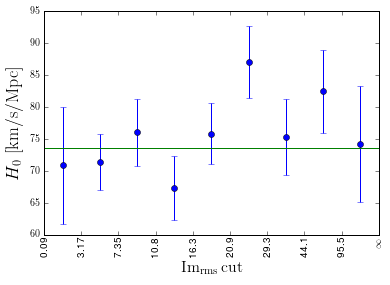

In [20]:
errorbar(arange(0.5, len(hvals)), hvals, yerr = herr, fmt = 'o')
model = CosmoModel(newcepheids, Sne)
result = model()
xvals = arange(-1, len(hvals)+1)
yvals = [model.H0] *xvals.size       
plot(xvals,yvals, color = 'g')
chi2val = (model.H0- array(hvals[:-1]))/array(herr[:-1])
#print 'chi2 is %3.2f'%chi2val
print sum(chi2val[1:]**2)
cutlist.append(r'$\infty$')
ylabel(r'$H_0 {\rm \, \,[km/s/Mpc]}$', fontsize = 18)
xlabel(r'${\rm Im}_{\rm rms} {\rm \, cut}$', fontsize = 16)
xticks(arange(len(hvals)+1),cutlist, rotation = 90)
xlim((0, len(hvals) ))
